In [1]:
# Inspecting Tokenization Internals

from transformers import AutoTokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
text = "Transformers are changing NLP forever."
tokens = tokenizer(text, return_tensors="pt")
print(tokens)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': tensor([[  101, 19081,  2024,  5278, 17953,  2361,  5091,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [2]:
# Converting input_ids back to tokens
print(tokenizer.convert_ids_to_tokens(tokens["input_ids"][0]))


['[CLS]', 'transformers', 'are', 'changing', 'nl', '##p', 'forever', '.', '[SEP]']


In [3]:
# Creating padded input manually:
tokens = tokenizer(
    text,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_tensors="pt"
)

print(tokens["attention_mask"])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [4]:
# Manual Forward Pass
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(
    model_name,
    output_hidden_states=True,
    output_attentions=True
)

outputs = model(**tokens)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [5]:
# analyzing hidden states
hidden_states = outputs.hidden_states
print(len(hidden_states))
print(hidden_states[0].shape)

13
torch.Size([1, 20, 768])


In [6]:
# Attention Weights Analysis
attentions = outputs.attentions
print(len(attentions))
print(attentions[0].shape)

12
torch.Size([1, 12, 20, 20])


['[CLS]', 'transformers', 'are', 'changing', 'nl', '##p', 'forever', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


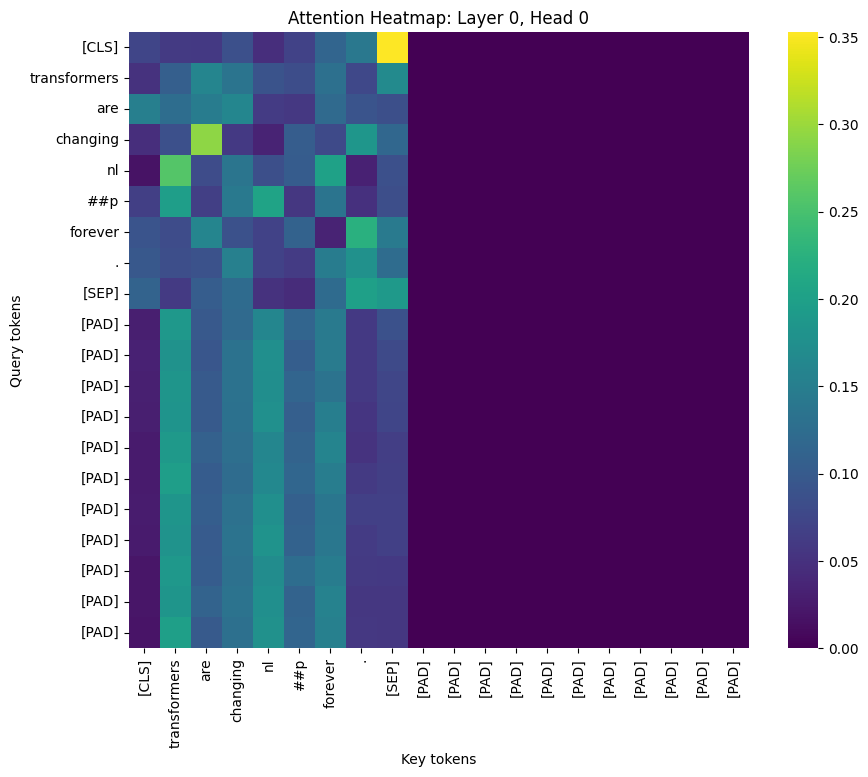

In [8]:
tokens_list = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
print(tokens_list)
import matplotlib.pyplot as plt
import seaborn as sns
layer_index = 0
head_index = 0
attention_matrix = attentions[layer_index][0, head_index, :, :]

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(attention_matrix.detach().numpy(), cmap='viridis',
            xticklabels=tokens_list, yticklabels=tokens_list)
plt.xlabel("Key tokens")
plt.ylabel("Query tokens")
plt.title(f"Attention Heatmap: Layer {layer_index}, Head {head_index}")
plt.show()

In [ ]:
"""
Task: Attention Interpretation
Take sentence:
“The animal didn’t cross the street because it was too tired.”
Find:
 Which word does “it” attend to most?
This shows coreference modeling.
Extract attention weights for the token index corresponding to “it”.
"""


from transformers import AutoTokenizer, AutoModel
import torch
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
text = "The animal didn’t cross the street because it was too tired."
tokens = tokenizer(text, return_tensors="pt")
tokens_list = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
print("Tokenized sentence:", tokens_list)
outputs = model(**tokens)
attentions = outputs.attentions
print("Number of layers:", len(attentions))
print("Attention matrix shape (layer 0):", attentions[0].shape)
it_index = (tokens['input_ids'] == tokenizer.convert_tokens_to_ids("it")).nonzero(as_tuple=True)[1].item()
print("Token index of 'it':", it_index)
last_layer_attention = attentions[-1]
it_attention_all_heads = last_layer_attention[0, :, it_index, :]
it_attention_mean = it_attention_all_heads.mean(dim=0)
max_index = torch.argmax(it_attention_mean).item()
print("Token 'it' attends most to:", tokens_list[max_index])

In [10]:
# Layer-wise Representation Evolution

from transformers import AutoTokenizer, AutoModel
import torch

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
text = "Transformers are changing NLP forever."
tokens = tokenizer(text, return_tensors="pt")
tokens_list = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
outputs = model(**tokens)
hidden_states = outputs.hidden_states
nlp_index = (tokens['input_ids'] == tokenizer.convert_tokens_to_ids("nl")).nonzero(as_tuple=True)[1].item()
print("Token index of 'NLP':", nlp_index)
embedding_layer = hidden_states[0][0, nlp_index, :]
middle_layer = hidden_states[6][0, nlp_index, :]
final_layer = hidden_states[-1][0, nlp_index, :]
print("Embedding layer vector:", embedding_layer[:10])
print("Middle layer vector:", middle_layer[:10])
print("Final layer vector:", final_layer[:10])

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Token index of 'NLP': 4
Embedding layer vector: tensor([ 0.1166, -0.7570,  0.1150, -1.1514,  0.8287, -0.3383,  0.1907,  0.3321,
        -0.8645, -0.8070], grad_fn=<SliceBackward0>)
Middle layer vector: tensor([ 1.6346, -1.3127,  0.4929, -1.4193,  2.0709, -0.4261,  1.1073, -0.4764,
        -0.0564, -0.5206], grad_fn=<SliceBackward0>)
Final layer vector: tensor([ 0.6514, -1.2727,  0.9387, -0.2254,  0.8818, -0.0572, -0.0868,  0.3699,
        -0.3994, -0.4305], grad_fn=<SliceBackward0>)


In [11]:
"""
Contextual Difference Experiment
Take two sentences:
1. “The bank approved the loan.”
2. “The river bank was beautiful.”
Tokenize both.
Extract final-layer embedding of “bank”.
Compute cosine similarity between the two embeddings.
"""

from transformers import AutoTokenizer, AutoModel
import torch
from torch.nn.functional import cosine_similarity

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
sentences = [
    "The bank approved the loan.",
    "The river bank was beautiful."
]

tokens_list_all = []
tokens_all = []

for sent in sentences:
    tokens = tokenizer(sent, return_tensors="pt")
    tokens_all.append(tokens)
    tokens_list_all.append(tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]))

for i, t in enumerate(tokens_list_all):
    print(f"Sentence {i+1} tokens:", t)



final_embeddings = []

for i, tokens in enumerate(tokens_all):
    outputs = model(**tokens)
    hidden_states = outputs.hidden_states
    tokens_list = tokens_list_all[i]
    bank_index = tokens_list.index("bank")
    final_layer = hidden_states[-1][0, bank_index, :]
    final_embeddings.append(final_layer)

print("Embeddings extracted for 'bank' in both sentences.")

similarity = cosine_similarity(final_embeddings[0], final_embeddings[1], dim=0)
print("Cosine similarity between 'bank' embeddings:", similarity.item())

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Sentence 1 tokens: ['[CLS]', 'the', 'bank', 'approved', 'the', 'loan', '.', '[SEP]']
Sentence 2 tokens: ['[CLS]', 'the', 'river', 'bank', 'was', 'beautiful', '.', '[SEP]']
Embeddings extracted for 'bank' in both sentences.
Cosine similarity between 'bank' embeddings: 0.49661076068878174
